<a href="https://colab.research.google.com/github/alitootoonchian/FinTech/blob/master/PredictStockRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

In [0]:
#import packages
from IPython.display import display
import pandas as pd
import numpy as np

import datetime as dt
import pandas_datareader.data  as pdr

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
%matplotlib inline

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

register_matplotlib_converters()

In [0]:
ticker = "AAPL"
end_date = dt.date.today()
start_date = end_date - dt.timedelta(365 * 10)
data = pdr.get_data_yahoo(ticker, start_date, end_date)
training_days = 60
training_itmes = (int)(len(data) * 0.7)
n_days = 1 

In [0]:
def build_price_model(data, training_days, training_itmes, n_days):
  dataset = data['Adj Close'].values.reshape(-1, 1)
  train = dataset[0:training_itmes, 0]

  #converting dataset into x_train and y_train
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(dataset)

  x_train , y_train = [], []
  for i in range(training_days, len(train)):
      x_train.append(scaled_data[i - training_days:i, 0])
      y_train.append(scaled_data[i, 0])

  x_train, y_train = np.array(x_train), np.array(y_train)

  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  #y_train = np.transpose(y_train)
  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(units=50, 
                 return_sequences=True, input_shape=(x_train.shape[1],1)))
  #model.add(Dropout(0.2))

  #model.add(LSTM(units = 50, return_sequences = True))
  #model.add(Dropout(0.2))

  #model.add(LSTM(units = 50, return_sequences = True))
  #model.add(Dropout(0.2))

  model.add(LSTM(units = 50, return_sequences=False))
  #model.add(Dropout(0.2))
  model.add(Dense(25))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(x_train, y_train, epochs=3, batch_size=1, verbose=2)

  return model, scaler

def predict_price(data, training_days, training_itmes, model, scaler):
  valid = data[training_itmes - training_days:]['Adj Close']
  valid = valid.values.reshape(-1, 1)
  inputs = scaler.transform(valid)

  X_test = []
  for i in range(training_days, inputs.shape[0]):
      X_test.append(inputs[i - training_days:i, 0])
  X_test = np.array(X_test)

  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
  closing_price = model.predict(X_test)
  closing_price = scaler.inverse_transform(closing_price)
  rms = np.sqrt(np.mean(np.power((valid[:, 0] - closing_price),2)))
  print("RMSE:{}".format(rms))
  return closing_price  

In [50]:
model, scaler = build_price_model(data, training_days, training_itmes, 1)

Epoch 1/3
 - 115s - loss: 2.9710e-04
Epoch 2/3
 - 113s - loss: 1.1686e-04
Epoch 3/3
 - 112s - loss: 7.5395e-05


In [51]:
closing_price = predict_price(data, training_days, training_itmes, model, scaler)

RMSE:60.96999834722624


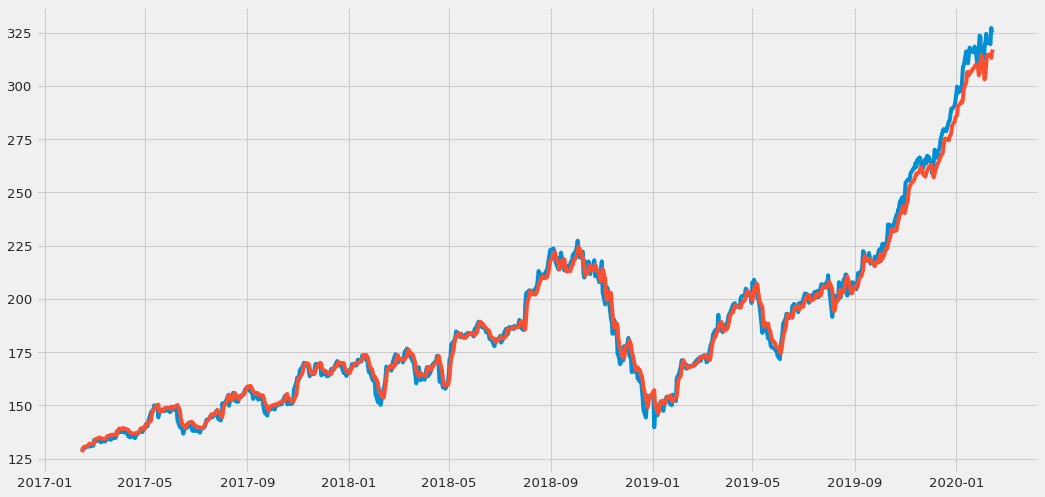

In [69]:
prediction = data.copy()
prediction.loc[-closing_price.shape[0]:, 'Predictions'] = closing_price[:,0]
prediction = prediction.dropna()
prediction = prediction.drop(["High", "Low", "Open", "Close", "Volume"], axis=1)
prediction['Diff'] = prediction['Adj Close'] - prediction['Predictions']
prediction['DiffPer'] = prediction['Diff'] / prediction['Adj Close']
prediction['DailyRet'] = prediction['Adj Close'].pct_change()
prediction['DailyRetPred'] = prediction['Predictions'].pct_change()
prediction['CumRet'] = (1 + prediction['DailyRet']).cumprod()
prediction['CumRetPred'] = (1 + prediction['DailyRetPred']).cumprod()
prediction['MonthDay'] = prediction.index.map(lambda x: str(x.month) + "-" + str(x.day))
prediction['Correct'] = prediction.apply (lambda row: -1 if (row['DailyRet'] * row['DailyRetPred'] < 0) else 1, axis=1)
plt.plot(prediction[['Adj Close', 'Predictions']])
plt.show()



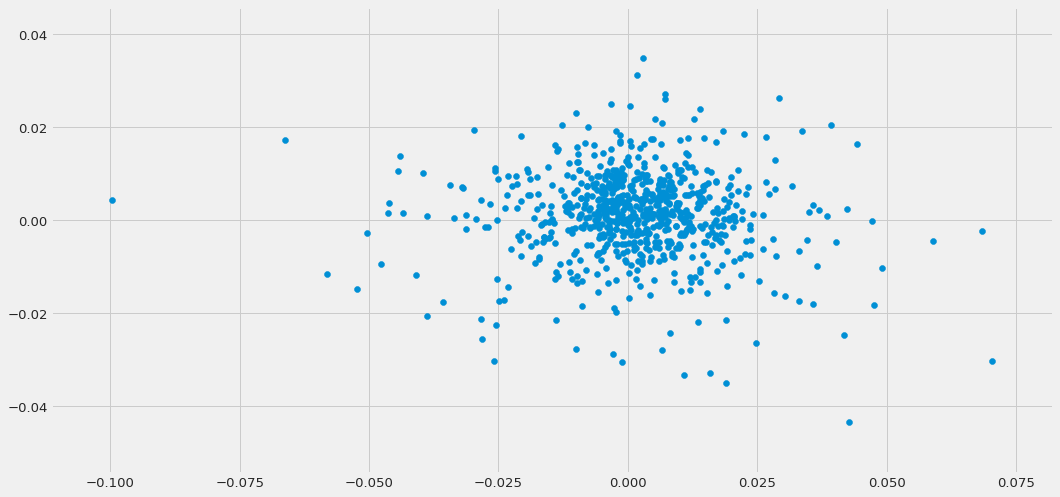

In [68]:
plt.scatter(x=prediction['DailyRet'], y=prediction['DailyRetPred'])
plt.show()

In [73]:
prediction[prediction.Correct == 1].shape[0] / prediction.shape[0]

0.4894179894179894